In [1]:
%%capture
!pip install pandas numpy matplotlib mplsoccer

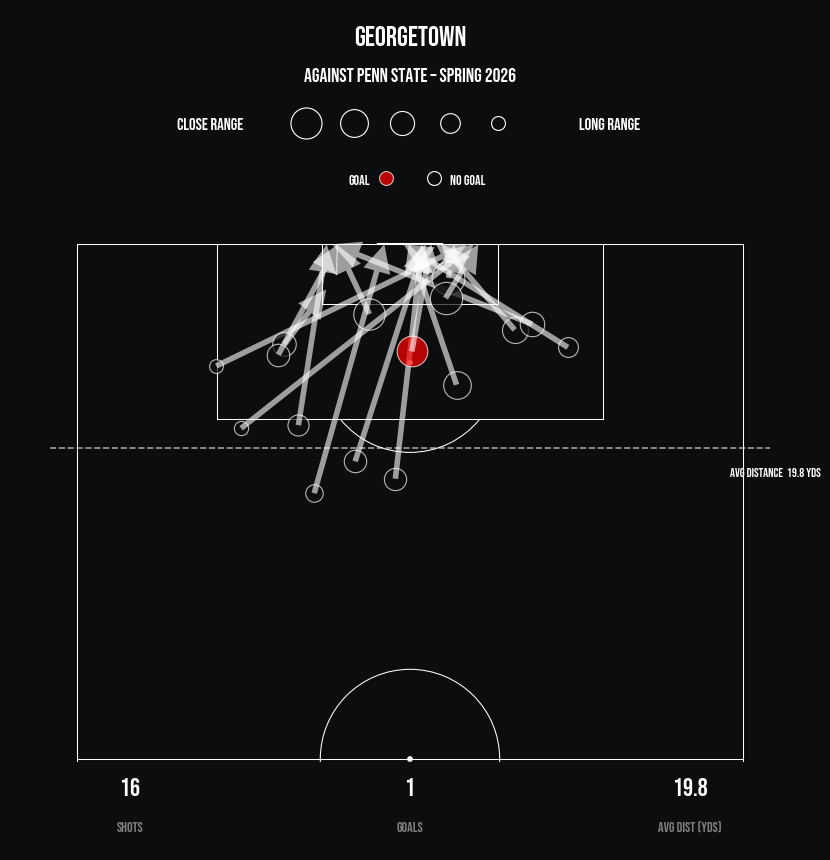

Saved → shotmap_output.png


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch, FontManager

# ── CONFIG ──────────────────────────────────────────────────────────────────
CSV_PATH = 'georgetownSpring.csv'   # ← change to your file
TEAM_NAME = 'Georgetown'            # ← label shown on the chart
SUBTITLE = 'Spring 2026'           # ← shown in the subtitle line
background_color = '#0C0D0E'

font_url = ('https://raw.githubusercontent.com/google/fonts/main/'
            'ofl/bebasneue/BebasNeue-Regular.ttf')
fm = FontManager(url=font_url)

# ── LOAD & FILTER ────────────────────────────────────────────────────────────
df_raw = pd.read_csv(CSV_PATH)

# Keep only Shot and Goal rows
df = df_raw[df_raw['Event Type'].isin(['Shot', 'Goal'])].copy()

df['Start X'] = df['Start X'].astype(float)
df['Start Y'] = df['Start Y'].astype(float)
df['End X']   = df['End X'].astype(float)
df['End Y']   = df_raw['End Y'].astype(float) # Add End Y

# ── NORMALIZE DIRECTION ──────────────────────────────────────────────────────
# Shots toward x=100 are already "attacking right".
# Shots toward x=0  are attacking the other end → mirror them.
# After mirroring every shot is attacking the goal at x=100.
#
# opta pitch: x 0→100, y 0→100
# Mirror: x_new = 100 - x,  y_new = 100 - y

attacking_right = df['End X'] >= 50          # shooting toward x=100

df.loc[~attacking_right, 'Start X'] = 100 - df.loc[~attacking_right, 'Start X']
df.loc[~attacking_right, 'Start Y'] = 100 - df.loc[~attacking_right, 'Start Y']
df.loc[~attacking_right, 'End X'] = 100 - df.loc[~attacking_right, 'End X'] # Mirror End X
df.loc[~attacking_right, 'End Y'] = 100 - df.loc[~attacking_right, 'End Y'] # Mirror End Y

# ── DISTANCE (used for legend sizing only) ───────────────────────────────────
# Goal mouth is at x=100, y=50 on opta
df['dist'] = np.sqrt((100 - df['Start X'])**2 + (50 - df['Start Y'])**2)

# Normalise size: closer = bigger circle
max_dist = df['dist'].max() if df['dist'].max() > 0 else 1
df['size'] = 600 * (1 - df['dist'] / (max_dist + 1)) + 80

# ── AVERAGE DISTANCE ─────────────────────────────────────────────────────────
# opta units ≈ yards when the pitch is ~100 yds long
average_distance = df['dist'].mean()
# For the vertical half-pitch we draw the line on the y-axis of ax2
# In VerticalPitch(half=True, pitch_type='opta'):
#   the x-axis of the subplot corresponds to opta-Y (width)
#   the y-axis of the subplot corresponds to opta-X (length)
# Scatter uses pitch.scatter(x=opta_X, y=opta_Y, ...) so the line is straightforward.
avg_line_x = 100 - average_distance   # opta-X position of average distance

# ── PITCH FIGURE ─────────────────────────────────────────────────────────────
pitch = VerticalPitch(
    pitch_type='opta',
    half=True,
    pitch_color=background_color,
    pad_bottom=.5,
    line_color='white',
    linewidth=.75,
    axis=True,
    label=True,
)

fig = plt.figure(figsize=(8, 12))
fig.patch.set_facecolor(background_color)

# ── TITLE AXES ───────────────────────────────────────────────────────────────
ax1 = fig.add_axes([0, 0.7, 1, .2])
ax1.set_facecolor(background_color)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

ax1.text(0.5, .85, TEAM_NAME,
         fontsize=20, fontproperties=fm.prop, fontweight='bold',
         color='white', ha='center')
ax1.text(0.5, .7, f'Against Penn State – {SUBTITLE}',
         fontsize=14, fontweight='bold', fontproperties=fm.prop,
         color='white', ha='center')

# Size legend
ax1.text(0.25, 0.5, 'Close Range', fontsize=12,
         fontproperties=fm.prop, color='white', ha='center')
for i, s in enumerate([500, 400, 300, 200, 100]):
    ax1.scatter(0.37 + i * 0.06, 0.53, s=s,
                color=background_color, edgecolor='white', linewidth=.8)
ax1.text(0.75, 0.5, 'Long Range', fontsize=12,
         fontproperties=fm.prop, color='white', ha='center')

# Goal / No Goal legend
ax1.text(0.45, 0.27, 'Goal', fontsize=10,
         fontproperties=fm.prop, color='white', ha='right')
ax1.scatter(0.47, 0.3, s=100, color='red', edgecolor='white', linewidth=.8, alpha=.7)
ax1.scatter(0.53, 0.3, s=100, color=background_color, edgecolor='white', linewidth=.8)
ax1.text(0.55, 0.27, 'No Goal', fontsize=10,
         fontproperties=fm.prop, color='white', ha='left')

ax1.set_axis_off()

# ── PITCH AXES ────────────────────────────────────────────────────────────────
ax2 = fig.add_axes([.05, 0.25, .9, .5])
ax2.set_facecolor(background_color)
pitch.draw(ax=ax2)

# Average-distance line (vertical line across width of pitch at avg_line_x opta-X)
# VerticalPitch draws opta-X along the vertical axis of ax2
ax2.axhline(y=avg_line_x, color='white', linewidth=1.2, linestyle='--', alpha=0.6)
ax2.text(
    x=2, y=avg_line_x - 2,
    s=f'Avg Distance  {average_distance:.1f} yds',
    fontsize=9, fontproperties=fm.prop,
    color='white', ha='left', va='top'
)

# ── PLOT SHOTS ────────────────────────────────────────────────────────────────
for _, row in df.iterrows():
    # Plot shot start location
    pitch.scatter(
        row['Start X'],
        row['Start Y'],
        s=row['size'],
        color='red' if row['Event Type'] == 'Goal' else background_color,
        ax=ax2,
        alpha=.7,
        linewidth=.8,
        edgecolor='white',
    )
    # Plot shot trajectory (arrow)
    pitch.arrows(
        xstart=row['Start X'],
        ystart=row['Start Y'],
        xend=row['End X'],
        yend=row['End Y'],
        ax=ax2,
        color='white',
        lw=1.5,
        alpha=0.6,
        headwidth=5,
        headlength=5,
        headaxislength=5
    )

# Stats strip
goals  = (df['Event Type'] == 'Goal').sum()
shots  = len(df)
on_tgt = (df['End X'] == 100).sum()   # End X == 100 means on target in original data

ax2.set_axis_off()

# ── STATS AXES ───────────────────────────────────────────────────────────────
ax3 = fig.add_axes([0, .2, 1, .06])
ax3.set_facecolor(background_color)
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)

stats = [
    ('Shots', str(shots)),
    ('Goals', str(goals)),
    ('Avg Dist (yds)', f'{average_distance:.1f}'),
]
for i, (label, val) in enumerate(stats):
    xpos = 0.15 + i * 0.35
    ax3.text(xpos, 0.75, val, fontsize=18, fontproperties=fm.prop,
             fontweight='bold', color='white', ha='center')
    ax3.text(xpos, 0.25, label, fontsize=10, fontproperties=fm.prop,
             color='grey', ha='center')

ax3.set_axis_off()

plt.savefig('shotmap_output.png', dpi=150, bbox_inches='tight',
            facecolor=background_color)
plt.show()
print("Saved → shotmap_output.png")

In [4]:
%%capture
!pip install mplsoccer statsbombpy pandas numpy matplotlib scikit-learn

In [39]:
TEAM_NAME = 'Penn State'

In [6]:
# ============================================================
#  Shot Map + xG Model
#  Trains a logistic regression on StatsBomb open data,
#  then applies it to your CSV.
#
#  Install deps first:
#    pip install mplsoccer statsbombpy pandas numpy matplotlib scikit-learn
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch, FontManager
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from statsbombpy import sb

# ── CONFIG ────────────────────────────────────────────────────────────────────
CSV_PATH         = 'georgetownSpring.csv'  # ← your file
TEAM_NAME        = 'Georgetown'
SUBTITLE         = 'Spring 2026'
background_color = '#0C0D0E'

# ── STEP 1: TRAIN xG MODEL ON STATSBOMB OPEN DATA ────────────────────────────
print("Loading StatsBomb open data to train xG model...")

TRAINING_COMPS = [
    (11, 90),   # La Liga 2020/21
    (2,  44),   # Premier League 2003/04
]

shot_records = []

for comp_id, season_id in TRAINING_COMPS:
    try:
        matches = sb.matches(competition_id=comp_id, season_id=season_id)
        for match_id in matches['match_id']:
            try:
                events = sb.events(match_id=match_id)
                shots = events[events['type'] == 'Shot'].copy()
                if shots.empty:
                    continue
                shots['sb_x'] = shots['location'].apply(lambda l: l[0])
                shots['sb_y'] = shots['location'].apply(lambda l: l[1])
                shots['is_goal'] = (shots['shot_outcome'].str.lower() == 'goal').astype(int)
                shots['is_penalty'] = shots['shot_type'].str.lower() == 'penalty'
                shot_records.append(shots[['sb_x', 'sb_y', 'is_goal', 'is_penalty']])
            except Exception:
                continue
    except Exception:
        continue

sb_shots = pd.concat(shot_records, ignore_index=True)
sb_shots = sb_shots[~sb_shots['is_penalty']].copy()

# ── Feature engineering on StatsBomb coords (pitch: 120x80 yards) ────────────
# Goal centre in StatsBomb coords: (120, 40)
GOAL_X_SB, GOAL_Y_SB = 120.0, 40.0
GOAL_WIDTH_SB = 7.32   # yards

def compute_features(x, y, goal_x, goal_y, goal_width):
    dx = goal_x - x
    dy = goal_y - y
    dist = np.sqrt(dx**2 + dy**2)

    # Angle subtended by the goal (law of cosines approach)
    a = np.sqrt(dx**2 + (dy - goal_width / 2)**2)
    b = np.sqrt(dx**2 + (dy + goal_width / 2)**2)
    cos_angle = (a**2 + b**2 - goal_width**2) / (2 * a * b)
    angle = np.degrees(np.arccos(np.clip(cos_angle, -1, 1)))

    return dist, angle

sb_shots['dist'], sb_shots['angle'] = compute_features(
    sb_shots['sb_x'].values, sb_shots['sb_y'].values,
    GOAL_X_SB, GOAL_Y_SB, GOAL_WIDTH_SB
)

X_train = sb_shots[['dist', 'angle']].values
y_train = sb_shots['is_goal'].values

print(f"Training xG model on {len(sb_shots):,} open-play shots from StatsBomb...")

xg_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)
xg_model.fit(X_train, y_train)
print("xG model trained ✓")

Loading StatsBomb open data to train xG model...
Training xG model on 1,731 open-play shots from StatsBomb...
xG model trained ✓


In [9]:
import pickle

# After fitting — save it
with open('xg_model.pkl', 'wb') as f:
    pickle.dump(xg_model, f)

# Future runs — just load it
with open('xg_model.pkl', 'rb') as f:
    xg_model = pickle.load(f)

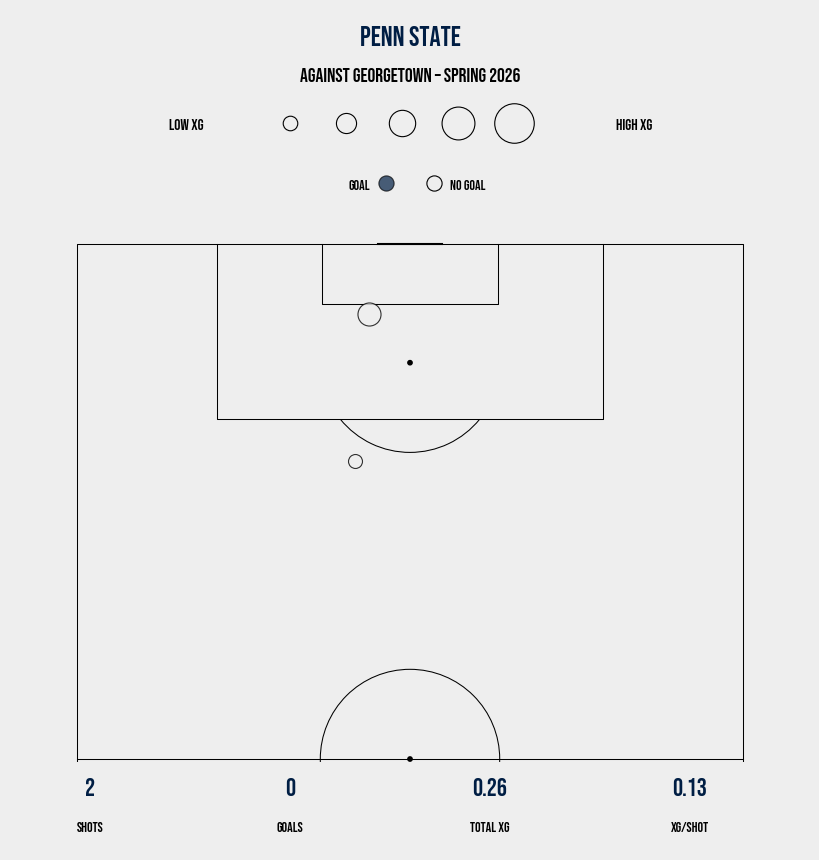


Done. Total xG: 0.26 from 2 shots, 0 goals.


In [40]:
background_color = '#EEEEEE'
font_color = '#000000'
team_color = '#001E44'

# ── STEP 2: LOAD & PREP YOUR CSV ─────────────────────────────────────────────
df_raw = pd.read_csv(CSV_PATH)
df = df_raw[df_raw['Event Type'].isin(['Shot', 'Goal'])].copy()
df = df[df['Player Team'] == 1]

df['Start X'] = df['Start X'].astype(float)
df['Start Y'] = df['Start Y'].astype(float)
df['End X']   = df['End X'].astype(float)

# Normalize direction: mirror shots toward x=0 so all attack x=100
attacking_right = df['End X'] >= 50
df.loc[~attacking_right, 'Start X'] = 100 - df.loc[~attacking_right, 'Start X']
df.loc[~attacking_right, 'Start Y'] = 100 - df.loc[~attacking_right, 'Start Y']

# df.loc[df.index[5], 'Start X'] = 88.5
# df.loc[df.index[5], 'Start Y'] = 50

# ── Convert opta (0–100) → StatsBomb (0–120 / 0–80) for feature calc ─────────
df['sb_x'] = df['Start X'] * 1.2
df['sb_y'] = df['Start Y'] * 0.8

df['dist'], df['angle'] = compute_features(
    df['sb_x'].values, df['sb_y'].values,
    GOAL_X_SB, GOAL_Y_SB, GOAL_WIDTH_SB
)

df['xG'] = xg_model.predict_proba(df[['dist', 'angle']])[:, 1]

# Circle size proportional to xG
df['size'] = df['xG'] * 1000 + 60

# ── STEP 3: PLOT ──────────────────────────────────────────────────────────────
font_url = ('https://raw.githubusercontent.com/google/fonts/main/'
            'ofl/bebasneue/BebasNeue-Regular.ttf')
fm = FontManager(url=font_url)

pitch = VerticalPitch(
    pitch_type='opta',
    half=True,
    pitch_color=background_color,
    pad_bottom=.5,
    line_color=font_color,
    linewidth=.75,
    axis=True,
    label=True,
)

fig = plt.figure(figsize=(8, 12))
fig.patch.set_facecolor(background_color)

# ── Title / legend axes ───────────────────────────────────────────────────────
ax1 = fig.add_axes([0, 0.7, 1, .2])
ax1.set_facecolor(background_color)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

ax1.text(0.5, .85, TEAM_NAME, fontsize=20, fontproperties=fm.prop,
         fontweight='bold', color=team_color, ha='center')
ax1.text(0.5, .70, f'Against Georgetown – {SUBTITLE}', fontsize=14,
         fontweight='bold', fontproperties=fm.prop, color=font_color, ha='center')

# xG size legend
ax1.text(0.22, 0.50, 'Low xG', fontsize=11, fontproperties=fm.prop,
         color=font_color, ha='center')
for i, xg_val in enumerate([0.05, 0.15, 0.30, 0.50, 0.75]):
    ax1.scatter(0.35 + i * 0.07, 0.53,
                s=xg_val * 1000 + 60,
                color=background_color, edgecolor=font_color, linewidth=.8)
ax1.text(0.78, 0.50, 'High xG', fontsize=11, fontproperties=fm.prop,
         color=font_color, ha='center')

# Goal / No Goal legend
ax1.text(0.45, 0.25, 'Goal', fontsize=10, fontproperties=fm.prop,
         color=font_color, ha='right')
ax1.scatter(0.47, 0.28, s=120, color=team_color, edgecolor=font_color,
            linewidth=.8, alpha=.7)
ax1.scatter(0.53, 0.28, s=120, color=background_color, edgecolor=font_color,
            linewidth=.8)
ax1.text(0.55, 0.25, 'No Goal', fontsize=10, fontproperties=fm.prop,
         color=font_color, ha='left')

ax1.set_axis_off()

# ── Pitch axes ────────────────────────────────────────────────────────────────
ax2 = fig.add_axes([.05, 0.25, .9, .5])
ax2.set_facecolor(background_color)
pitch.draw(ax=ax2)

# Scatter shots — sized and colored by xG
for _, row in df.iterrows():
    pitch.scatter(
        row['Start X'],
        row['Start Y'],
        s=row['size'],
        color=team_color if row['Event Type'] == 'Goal' else background_color,
        ax=ax2,
        alpha=.8,
        linewidth=.8,
        edgecolor=font_color,
    )

ax2.set_axis_off()

# ── Stats strip ───────────────────────────────────────────────────────────────
ax3 = fig.add_axes([0, .2, 1, .06])
ax3.set_facecolor(background_color)
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)

goals    = (df['Event Type'] == 'Goal').sum()
shots    = len(df)
total_xg = df['xG'].sum()

stats = [
    ('Shots',    str(shots)),
    ('Goals',    str(goals)),
    ('Total xG', f'{total_xg:.2f}'),
    ('xG/Shot',  f'{total_xg/shots:.2f}' if shots else '—'),
]
for i, (label, val) in enumerate(stats):
    xpos = 0.10 + i * 0.25
    ax3.text(xpos, 0.75, val, fontsize=18, fontproperties=fm.prop,
             fontweight='bold', color=team_color, ha='center')
    ax3.text(xpos, 0.25, label, fontsize=10, fontproperties=fm.prop,
             color=font_color, ha='center')

ax3.set_axis_off()

plt.savefig('psu_shotmap_xg_output.png', dpi=150, bbox_inches='tight',
            facecolor=background_color)
plt.show()
print(f"\nDone. Total xG: {total_xg:.2f} from {shots} shots, {goals} goals.")

In [32]:
df

,ID,Video Timestamp,Video Time (MM:SS),Player ID,Player Name,Player Team,Event Type,Start X,Start Y,End X,End Y,Drill Type,Session ID,Created At,sb_x,sb_y,dist,angle,xG,size
0,88d5999a-58d1-415a-8674-e2f6d0787855,0.0,00:00,1,Georgetown,2,Shot,82.43,66.74,100.00,62.49,NaN,NaN,2026-02-21T18:02:51.403Z,98.916,53.392,24.977604,14.187509,0.044282,104.281585
5,1de6923b-1cdc-4a5e-af1d-2cba81d95ef5,0.0,00:00,1,Georgetown,2,Shot,88.18,79.05,100.00,41.45,NaN,NaN,2026-02-21T18:15:03.803Z,105.816,63.240,27.226521,8.117983,0.032986,92.986147
8,857689ca-95e6-4d4d-a349-b9a6e04824ec,0.0,00:00,1,Georgetown,2,Shot,86.36,43.02,100.00,50.18,NaN,NaN,2026-02-21T18:20:18.871Z,103.632,34.416,17.294290,22.751896,0.095626,155.625997
9,5019dea2-9eef-4e5c-8a3f-d0f2f84b8662,0.0,00:00,1,Georgetown,2,Shot,91.69,34.29,100.00,45.25,NaN,NaN,2026-02-21T18:24:13.734Z,110.028,27.432,16.043547,16.655092,0.095473,155.472719
12,e3984aca-8881-4ccd-b020-4ddf4803bfe1,0.0,00:00,1,Georgetown,2,Shot,77.23,52.19,100.00,48.16,NaN,NaN,2026-02-21T18:26:19.336Z,92.676,41.752,27.380111,15.197842,0.036866,96.866498
13,ea551cac-766d-4f97-83c0-6e04fb048e42,0.0,00:00,1,Georgetown,2,Goal,88.50,50.00,100.00,46.82,NaN,NaN,2026-02-21T18:27:51.875Z,106.200,40.000,13.800000,29.707729,0.139921,199.920921
17,ede3b457-055f-4940-87e2-f0eb5747a3c0,0.0,00:00,1,Georgetown,2,Shot,92.24,31.69,0.00,38.32,NaN,NaN,2026-02-21T19:01:59.161Z,110.688,25.352,17.357340,13.321015,0.081389,141.388966
18,dd7c1787-9349-4f13-afab-e918daa82d8f,0.0,00:00,1,Georgetown,2,Shot,75.82,64.37,0.00,46.15,NaN,NaN,2026-02-21T19:09:05.514Z,90.984,51.496,31.210355,12.466862,0.025425,85.425174
19,c4ea5b46-7d49-4fe8-a1d2-2bb8213e031c,0.0,00:00,1,Georgetown,2,Shot,96.73,44.23,0.00,56.67,NaN,NaN,2026-02-21T19:09:45.907Z,116.076,35.384,6.058484,50.940230,0.319594,379.594148
20,b7e721d9-7f9e-406a-b144-0abd6e0a6811,0.0,00:00,1,Georgetown,2,Shot,90.28,68.85,4.39,37.42,NaN,NaN,2026-02-21T19:15:11.195Z,108.336,55.080,19.064504,13.706971,0.071401,131.400685
